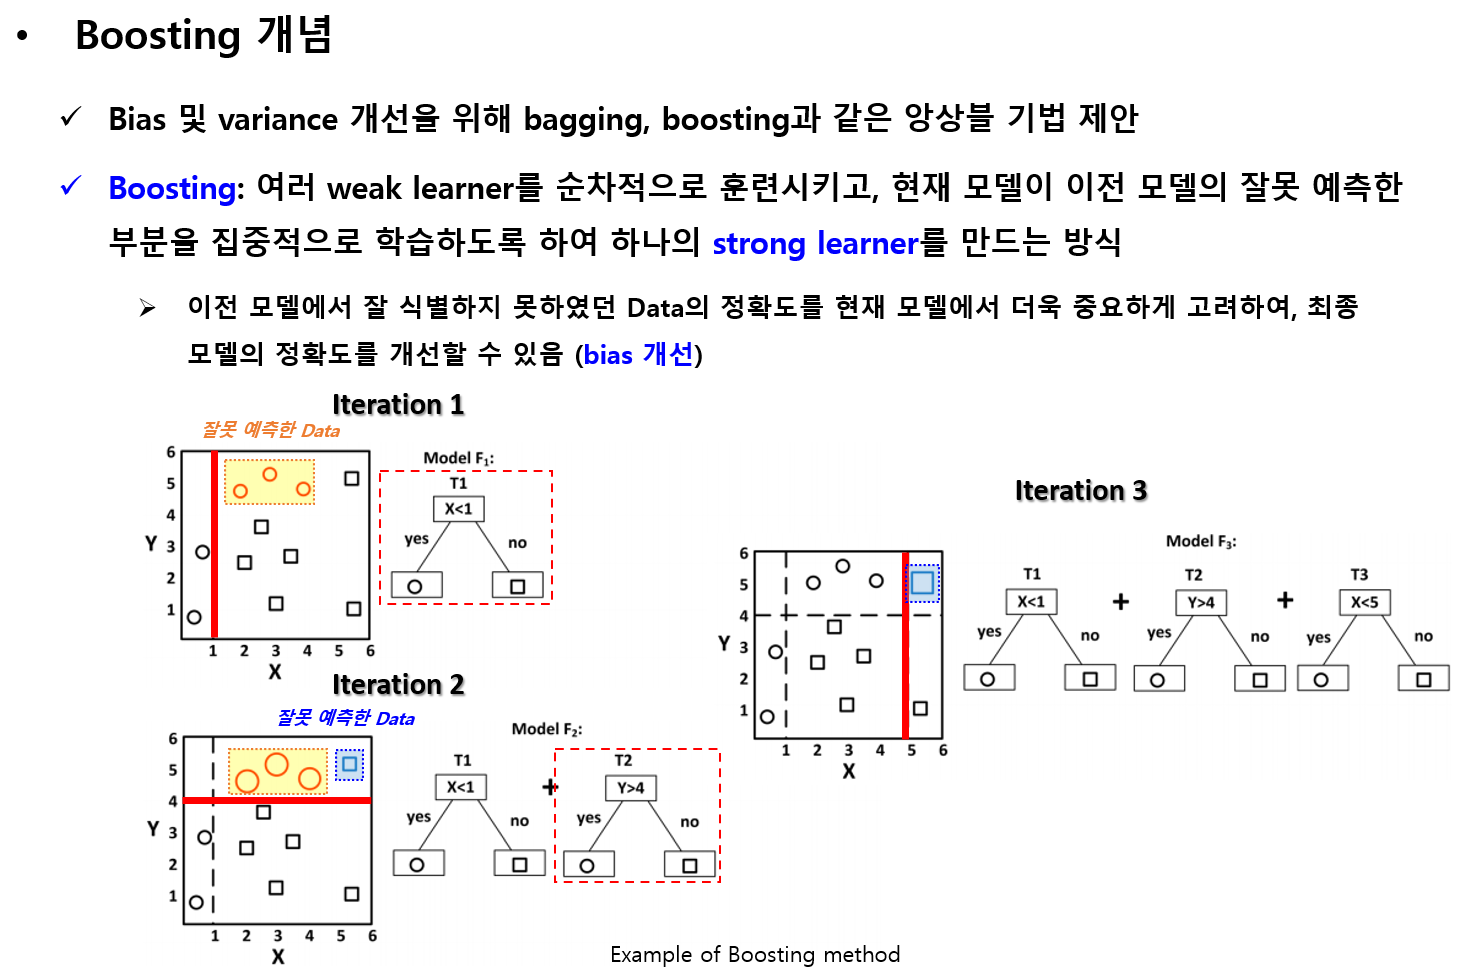

## **[Regression] 발전소 전기 에너지 출력(PE) 예측**

In [1]:
# 필요한 기본 package 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
!git clone https://github.com/yun-seon/LGES_DX-Expert_0619.git

fatal: destination path 'LGES_DX-Expert_0619' already exists and is not an empty directory.


In [3]:
'''
CCPP Data : 6년 간(2006-2011) 발전소가 최대 부하로 작동할 때 시간당 순수 전기 에너지 출력(PE)를
평균 주변 온도(AT), 주변 압력(AP), 상대 습도(RH), 배기 진공(V) 센서 데이터를 이용해 예측하는 데이터
'''

# 데이터 불러오기
dt = pd.read_csv("/content/LGES_DX-Expert_0619/CCPP.csv", encoding = "UTF-8-sig")
dt.head(10)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
5,26.27,59.44,1012.23,58.77,443.67
6,15.89,43.96,1014.02,75.24,467.35
7,9.48,44.71,1019.12,66.43,478.42
8,14.64,45.00,1021.78,41.25,475.98
9,11.74,43.56,1015.14,70.72,477.50


In [4]:
# 데이터 타입(type) 확인
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [5]:
'''
결측치가 존재할 경우, 특정 값(0)으로 replace 가능
df.replace(np.nan,'0',inplace = True)
'''

# 데이터 결측치 확인
dt.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [6]:
# 데이터 분포(통계량) 확인
dt.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


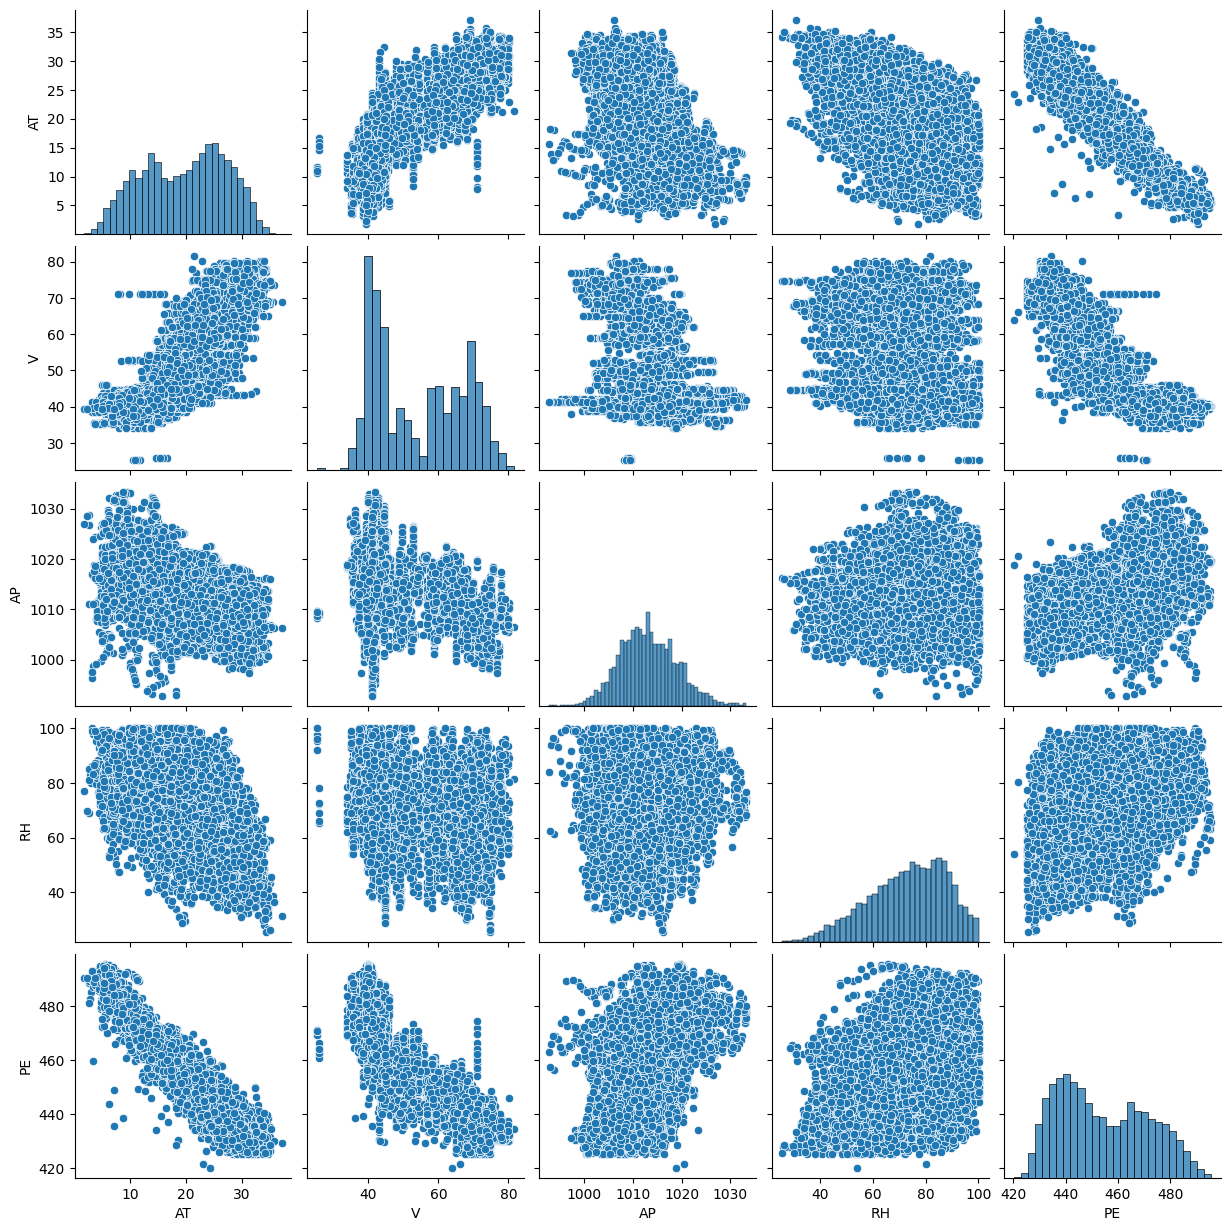

In [7]:
# 데이터 분포(그래프) 확인
sns.pairplot(dt)

In [8]:
# 변수 별 상관계수
dt.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


In [9]:
# 학습 데이터와 테스트 데이터 구분

# 학습 데이터 비율: 0.7, 테스트 데이터 비율: 0.3
train_data, test_data = train_test_split(dt, train_size = 0.7)

# 독립변수(Xs)와 종속변수(Y) 구분
X_train = train_data.iloc[:, :-1].reset_index(drop = True) # train_X에 종속변수 제거
y_train = train_data.iloc[:, -1].reset_index(drop = True) # train_Y(종속변수) 따로 저장

X_test = test_data.iloc[:, :-1].reset_index(drop = True) # test_X에 종속변수 제거
y_test = test_data.iloc[:, -1].reset_index(drop = True) # test_Y(종속변수) 따로 저장

In [10]:
X_test.head()

,AT,V,AP,RH
0,25.76,65.48,1017.82,54.77
1,16.37,36.99,1006.37,90.11
2,17.33,53.16,1013.77,82.77
3,22.99,62.96,1019.60,65.05
4,19.69,56.65,1020.79,66.94


In [11]:
# GBM 모델(예측) package 불러오기
from sklearn.ensemble import GradientBoostingRegressor

#모델 파라미터 설정
'''
파라미터 목록: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
'''
gbm = GradientBoostingRegressor(loss          = "squared_error",
                                learning_rate = 0.1,
                                n_estimators  = 100,
                                criterion     = "squared_error", # mse = squared_error
                                max_depth     = 3,
                                min_samples_split = 2,
                                min_samples_leaf  = 1,
                                verbose = 1)

#설정된 모델 파라미터에 데이터 fitting (GBM 학습)
gbm.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         239.9490            1.35s
         2         199.1514            1.50s
         3         165.9482            1.41s
         4         138.9342            1.57s
         5         116.9116            1.97s
         6          98.9452            1.89s
         7          84.3168            1.85s
         8          72.2060            1.75s
         9          62.4153            1.72s
        10          54.4264            1.66s
        20          22.1935            1.87s
        30          16.7628            1.67s
        40          15.3394            1.64s
        50          14.7069            1.48s
        60          14.3953            1.25s
        70          14.0502            0.91s
        80          13.7910            0.61s
        90          13.6172            0.30s
       100          13.2532            0.00s


GradientBoostingRegressor(criterion='squared_error', verbose=1)

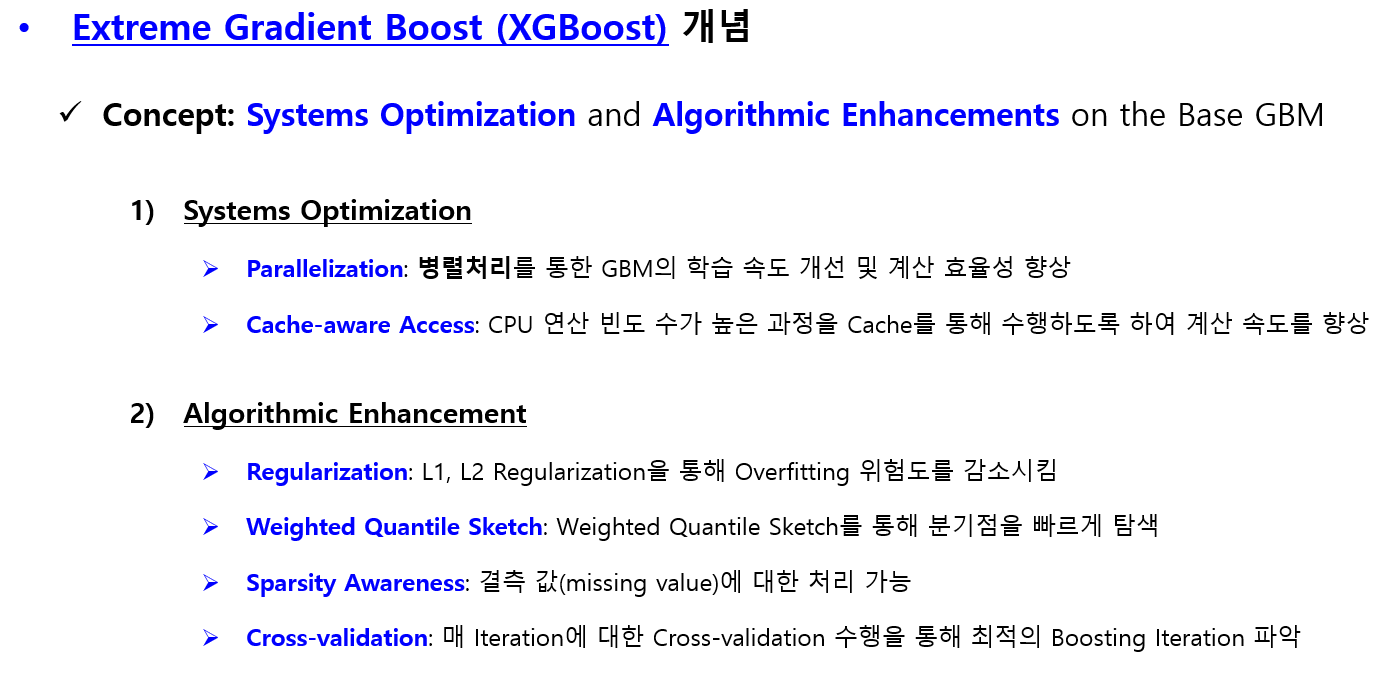

In [12]:
from xgboost import XGBRegressor

'''
Parameter 참고: https://xgboost.readthedocs.io/en/stable/parameter.html
'''

xgb = XGBRegressor(n_estimators=100,
                   learning_rate=0.01,
                   subsample=0.75,
                   max_depth=7)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

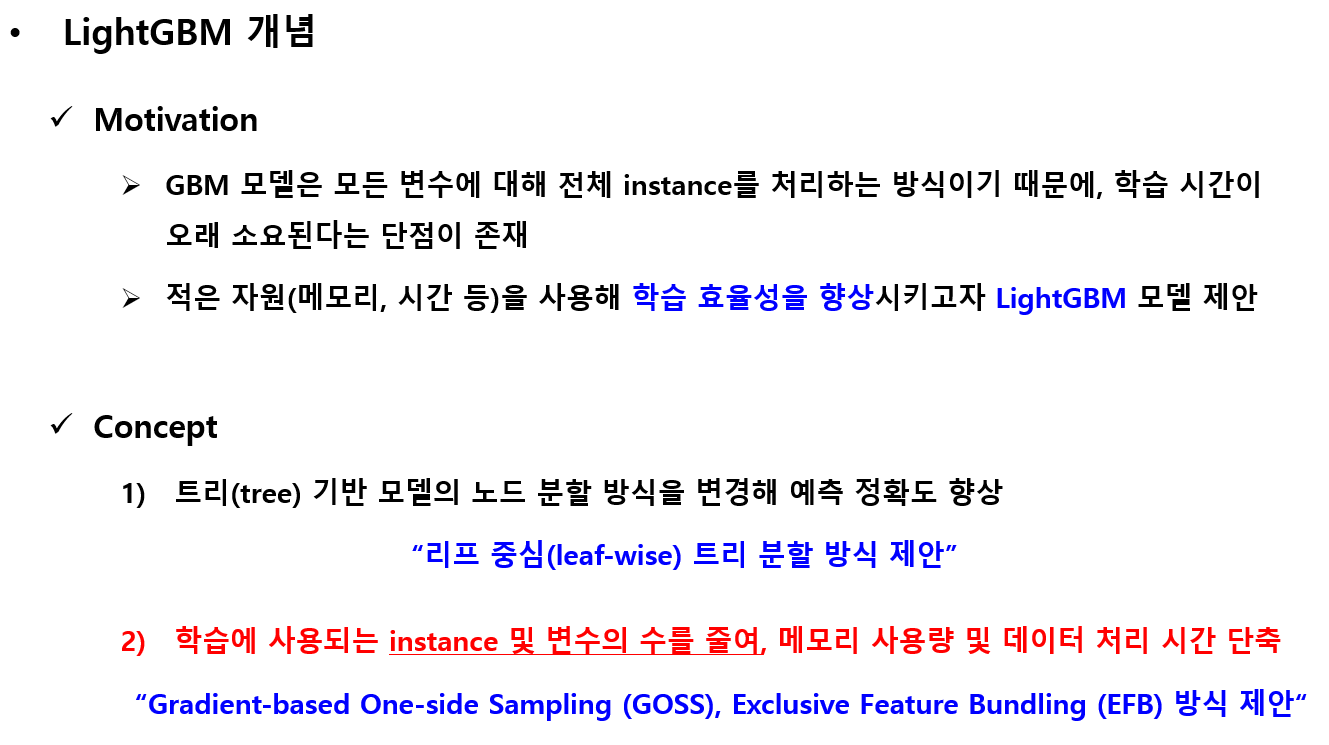

In [13]:
from lightgbm import LGBMRegressor
'''
Parameter 참고: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

boosting type:
    'gbdt' (traditional Gradient Boosting Decision Tree), 'dart' (Multiple Additive Regression Trees), 'goss' (Gradient-based One-side Sampling), 'rf' (Random Forest)
'''
lgbm = LGBMRegressor(learning_rate    = 0.01,
                      boosting_type    = 'goss',
                      max_depth        = 10)

lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 6697, number of used features: 4
[LightGBM] [Info] Using GOS

LGBMRegressor(boosting_type='goss', learning_rate=0.01, max_depth=10)

In [14]:
# 학습한 GBM 모델을 통해 테스트 데이터 예측

# pred 변수에 실제값 추가
predictions = pd.DataFrame(y_test)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
predictions["gbm_pred"] = gbm.predict(X_test)
predictions["xgb_pred"] = xgb.predict(X_test)
predictions["lgbm_pred"] = lgbm.predict(X_test)

# 예측 결과 확인 (첫 10 instances)
predictions.head(10)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


,PE,gbm_pred,xgb_pred,lgbm_pred
0,441.14,443.553730,447.907074,447.679621
1,463.76,463.306176,460.218628,459.830584
2,459.78,458.016014,456.798737,456.929570
3,449.40,447.133955,449.794403,449.010308
4,457.17,455.671880,455.446960,454.520913
5,472.32,471.813193,464.561493,465.548288
6,433.15,432.029097,440.489105,440.533708
7,443.92,444.649389,446.058197,446.025303
8,478.08,479.157916,470.370697,470.427944
9,453.99,452.765367,453.419342,453.107670


- 예측 모델 평가지표

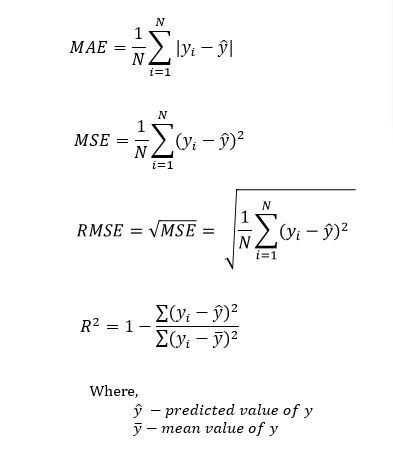

In [15]:
# GBM Regressor 기준, 예측 값과 실제 값 간의 오차 확인

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(predictions.PE, predictions.gbm_pred)
print("MAE : ", MAE)

# Mean Squared Error (MSE)
MSE = mean_squared_error(predictions.PE, predictions.gbm_pred)
print("MSE : ", MSE)

# Rooted Mean Squared Error (RMSE)
RMSE = np.sqrt(mean_squared_error(predictions.PE, predictions.gbm_pred))
print("RMSE : ", RMSE)

# 예측 값과 실제 값 간의 R^2(결정 계수) 계산
# 분산 기반으로 예측 성능을 평가 / 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높음
r2 = r2_score(predictions.PE, predictions.gbm_pred)
print("R-squared : ", r2)

MAE :  2.9596567766086035
MSE :  15.218490208745191
RMSE :  3.90108833644474
R-squared :  0.948181902659684


In [16]:
# XGB Regressor 기준, 예측 값과 실제 값 간의 오차 확인

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(predictions.PE, predictions.xgb_pred)
print("MAE : ", MAE)

# Mean Squared Error (MSE)
MSE = mean_squared_error(predictions.PE, predictions.xgb_pred)
print("MSE : ", MSE)

# Rooted Mean Squared Error (RMSE)
RMSE = np.sqrt(mean_squared_error(predictions.PE, predictions.xgb_pred))
print("RMSE : ", RMSE)

# 예측 값과 실제 값 간의 R^2(결정 계수) 계산
# 분산 기반으로 예측 성능을 평가 / 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높음
r2 = r2_score(predictions.PE, predictions.xgb_pred)
print("R-squared : ", r2)

MAE :  6.179532426909177
MSE :  54.69563643973868
RMSE :  7.395649832147185
R-squared :  0.8137644553270965


In [17]:
# LGBM Regressor 기준, 예측 값과 실제 값 간의 오차 확인

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(predictions.PE, predictions.lgbm_pred)
print("MAE : ", MAE)

# Mean Squared Error (MSE)
MSE = mean_squared_error(predictions.PE, predictions.lgbm_pred)
print("MSE : ", MSE)

# Rooted Mean Squared Error (RMSE)
RMSE = np.sqrt(mean_squared_error(predictions.PE, predictions.lgbm_pred))
print("RMSE : ", RMSE)

# 예측 값과 실제 값 간의 R^2(결정 계수) 계산
# 분산 기반으로 예측 성능을 평가 / 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높음
r2 = r2_score(predictions.PE, predictions.lgbm_pred)
print("R-squared : ", r2)

MAE :  6.252390845325991
MSE :  55.78587156012412
RMSE :  7.468994012591262
R-squared :  0.8100522664820099


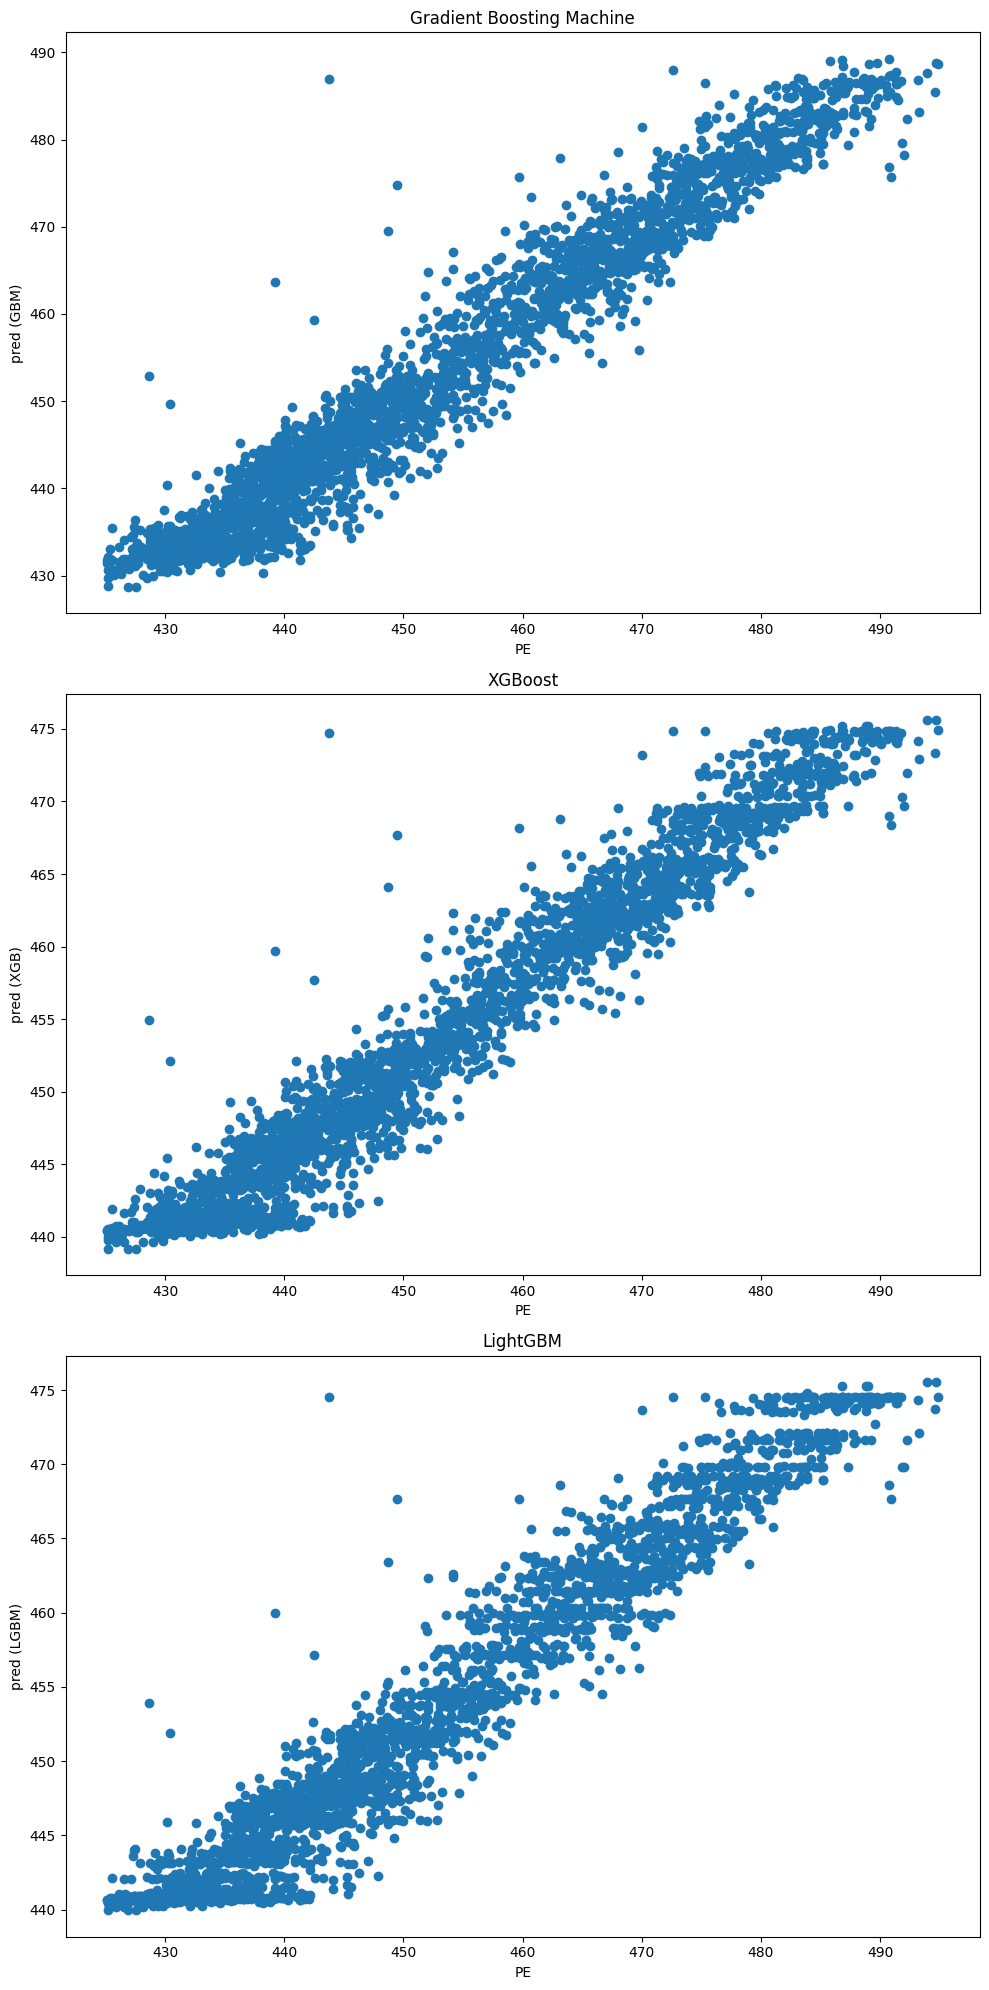

In [18]:
# 오차 Plot
plt.figure(figsize=(10, 20))

# 첫 번째 서브플롯
plt.subplot(3, 1, 1)
plt.title("Gradient Boosting Machine")
plt.scatter(predictions.PE, predictions.gbm_pred)
plt.xlabel("PE")
plt.ylabel("pred (GBM)")

# 두 번째 서브플롯
plt.subplot(3, 1, 2)
plt.title("XGBoost")
plt.scatter(predictions.PE, predictions.xgb_pred)
plt.xlabel("PE")
plt.ylabel("pred (XGB)")

# 세 번째 서브플롯
plt.subplot(3, 1, 3)
plt.title("LightGBM")
plt.scatter(predictions.PE, predictions.lgbm_pred)
plt.xlabel("PE")
plt.ylabel("pred (LGBM)")

# 플롯 표시
plt.tight_layout()
plt.show()

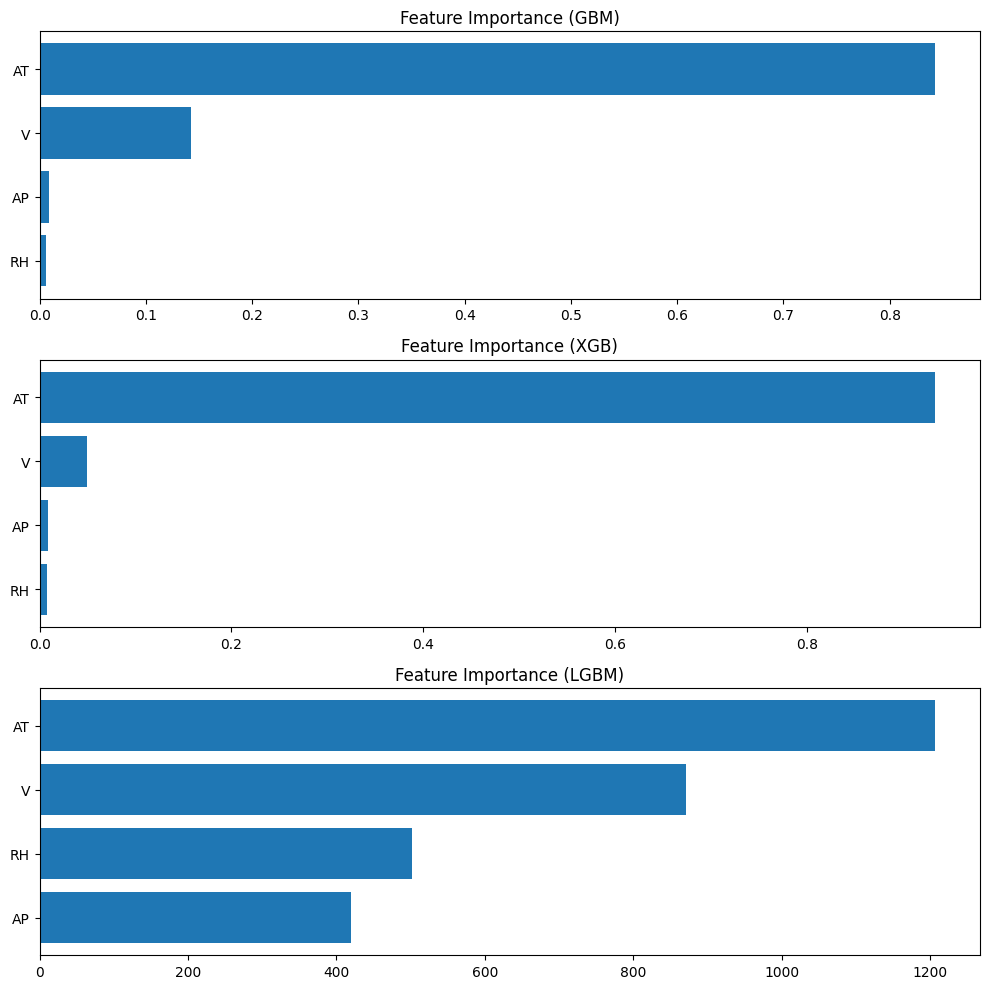

In [19]:
# feature importance 산출 / feature importance 값이 높을수록 feature 중요도가 높다고 해석할 수 있음
plt.figure(figsize=(10, 10))

# 첫 번째 서브플롯
plt.subplot(3, 1, 1)
# feature importance 산출 / feature importance 값이 높을수록 feature 중요도가 높다고 해석할 수 있음
feature_importance = gbm.feature_importances_
# feature_importance를 높은 순서로 정렬
sorted_idx = np.argsort(feature_importance)
# 변수 중요도 plot의 X축 길이를 선정하기 위한 설정
pos = np.arange(sorted_idx.shape[0]) + .5
# Bar chart 시각화
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(dt.columns)[sorted_idx])
plt.title('Feature Importance (GBM)')

# 두 번째 서브플롯
plt.subplot(3, 1, 2)
# feature importance 산출 / feature importance 값이 높을수록 feature 중요도가 높다고 해석할 수 있음
feature_importance = xgb.feature_importances_
# feature_importance를 높은 순서로 정렬
sorted_idx = np.argsort(feature_importance)
# 변수 중요도 plot의 X축 길이를 선정하기 위한 설정
pos = np.arange(sorted_idx.shape[0]) + .5
# Bar chart 시각화
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(dt.columns)[sorted_idx])
plt.title('Feature Importance (XGB)')

# 세 번째 서브플롯
plt.subplot(3, 1, 3)
# feature importance 산출 / feature importance 값이 높을수록 feature 중요도가 높다고 해석할 수 있음
feature_importance = lgbm.feature_importances_
# feature_importance를 높은 순서로 정렬
sorted_idx = np.argsort(feature_importance)
# 변수 중요도 plot의 X축 길이를 선정하기 위한 설정
pos = np.arange(sorted_idx.shape[0]) + .5
# Bar chart 시각화
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(dt.columns)[sorted_idx])
plt.title('Feature Importance (LGBM)')

# 플롯 표시
plt.tight_layout()
plt.show()

Correlation for train data: 0.3876773920358147, Correlation for test data: 0.3947454455491082


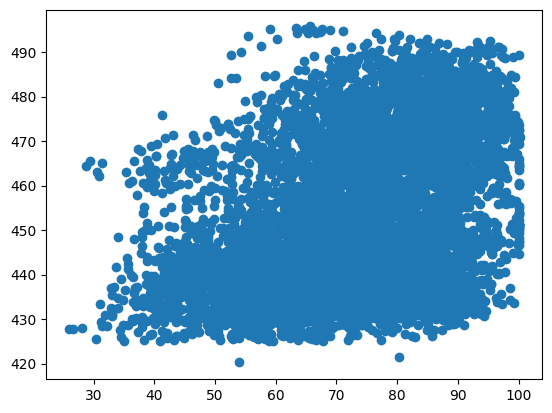

In [20]:
plt.scatter(X_train.RH, y_train)
print(f"Correlation for train data: {np.corrcoef(X_train.RH, y_train)[0, 1]}, Correlation for test data: {np.corrcoef(X_test.RH, y_test)[0, 1]}")
plt.show()

Correlation for train data: 0.5111094189533716, Correlation for test data: 0.5358186678223749


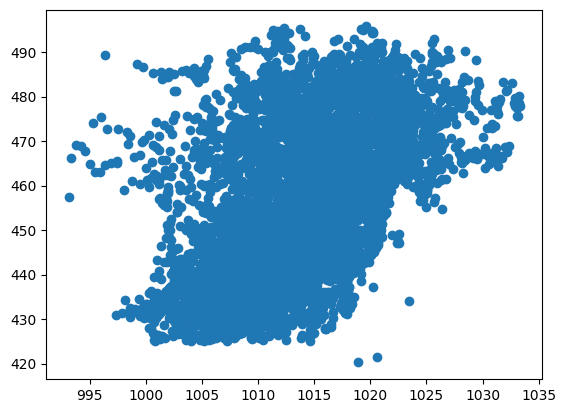

In [21]:
plt.scatter(X_train.AP, y_train)
print(f"Correlation for train data: {np.corrcoef(X_train.AP, y_train)[0, 1]}, Correlation for test data: {np.corrcoef(X_test.AP, y_test)[0, 1]}")
plt.show()